In [61]:
import numpy as np
import pandas as pd
import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()
np.random.seed(42)  

# Probabilities of each response type in the MPT model
prob_correct = 0.5      # Probability of a correct response
prob_semantic_error = 0.2  # Probability of a semantic error
prob_formal_error = 0.1    # Probability of a formal error
prob_unrelated_error = 0.1  # Probability of an unrelated error
prob_neologism = 0.05       # Probability of a neologism
prob_no_response = 0.05     # Probability of no response

# Simulating the data
num_trials = 1000  
categories = ['correct', 'semantic_error', 'formal_error', 'unrelated_error', 'neologism', 'no_response']
probabilities = [prob_correct, prob_semantic_error, prob_formal_error, prob_unrelated_error, prob_neologism, prob_no_response]

data = np.random.multinomial(1, probabilities, size=num_trials)
simulated_data = pd.DataFrame(data, columns=categories)

# Adding a column to sum the trials for each category
simulated_data_counts = simulated_data.sum().to_dict()

# Output the first few rows of our simulated dataset
simulated_data.head()

# Now let's construct the MPT model in Stan
stan_model_code = """
data {
    int<lower=0> correct;
    int<lower=0> semantic_error;
    int<lower=0> formal_error;
    int<lower=0> unrelated_error;
    int<lower=0> neologism;
    int<lower=0> no_response;
    int<lower=0> num_trials;
}

parameters {
    real<lower=0, upper=1> p_correct;
    real<lower=0, upper=1> p_semantic_given_incorrect;
    real<lower=0, upper=1> p_formal_given_incorrect_semantic;
    real<lower=0, upper=1> p_unrelated_given_incorrect_semantic_formal;
}

model {
    correct ~ binomial(num_trials, p_correct);
    semantic_error ~ binomial(num_trials - correct, p_semantic_given_incorrect);
    formal_error ~ binomial(num_trials - correct - semantic_error, p_formal_given_incorrect_semantic);
    unrelated_error ~ binomial(num_trials - correct - semantic_error - formal_error, p_unrelated_given_incorrect_semantic_formal);
    // Assuming neologism and no_response are the remaining out of total trials
}

generated quantities {
    int predicted_correct = binomial_rng(num_trials, p_correct);
    int predicted_semantic_error = binomial_rng(num_trials - predicted_correct, p_semantic_given_incorrect);
    int predicted_formal_error = binomial_rng(num_trials - predicted_correct - predicted_semantic_error, p_formal_given_incorrect_semantic);
    int predicted_unrelated_error = binomial_rng(num_trials - predicted_correct - predicted_semantic_error - predicted_formal_error, p_unrelated_given_incorrect_semantic_formal);
    int predicted_neologism = num_trials - predicted_correct - predicted_semantic_error - predicted_formal_error - predicted_unrelated_error;
    int predicted_no_response = num_trials - predicted_correct - predicted_semantic_error - predicted_formal_error - predicted_unrelated_error - predicted_neologism;
}

"""

# Create a dictionary that holds our simulated counts for each category
stan_data = {
    'correct': simulated_data_counts['correct'],
    'semantic_error': simulated_data_counts['semantic_error'],
    'formal_error': simulated_data_counts['formal_error'],
    'unrelated_error': simulated_data_counts['unrelated_error'],
    'neologism': simulated_data_counts['neologism'],
    'no_response': simulated_data_counts['no_response'],
    'num_trials': num_trials,
}
# Compile the model
model = stan.build(stan_model_code,data=stan_data)

# Sample from the model
fit = model.sample()

# Print a summary of the fit
print(fit)


Building...



Building: found in cache, done.Sampling:   0%
Sampling:  25% (2000/8000)
Sampling:  50% (4000/8000)
Sampling:  75% (6000/8000)
Sampling: 100% (8000/8000)
Sampling: 100% (8000/8000), done.
Messages received during sampling:
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 1e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.1 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 8e-06 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.08 seconds.
  Adjust your expectations accordingly!
  Gradient evaluation took 2e-05 seconds
  1000 transitions using 10 leapfrog steps per transition would take 0.2 seconds.
  Adjust your expectations accordingly!


<stan.Fit>
Parameters:
    p_correct: ()
    p_semantic_given_incorrect: ()
    p_formal_given_incorrect_semantic: ()
    p_unrelated_given_incorrect_semantic_formal: ()
    predicted_correct: ()
    predicted_semantic_error: ()
    predicted_formal_error: ()
    predicted_unrelated_error: ()
    predicted_neologism: ()
    predicted_no_response: ()
Draws: 4000


In [62]:
az.summary(fit)

/usr/local/lib/python3.10/dist-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_correct,0.510,0.016,0.482,0.542,0.000,0.000,4622.0,2942.0,1.0
p_semantic_given_incorrect,0.392,0.022,0.351,0.433,0.000,0.000,4667.0,2958.0,1.0
p_formal_given_incorrect_semantic,0.357,0.027,0.306,0.405,0.000,0.000,4310.0,3422.0,1.0
p_unrelated_given_incorrect_semantic_formal,0.510,0.036,0.446,0.578,0.001,0.000,4366.0,2580.0,1.0
predicted_correct,510.082,22.187,467.000,550.000,0.325,0.230,4646.0,3764.0,1.0
predicted_semantic_error,191.585,17.523,158.000,223.000,0.258,0.183,4623.0,3921.0,1.0
predicted_formal_error,106.427,13.708,80.000,131.000,0.204,0.145,4501.0,3854.0,1.0
predicted_unrelated_error,97.645,13.098,72.000,121.000,0.219,0.155,3583.0,3819.0,1.0
predicted_neologism,94.261,13.390,70.000,118.000,0.205,0.145,4248.0,3609.0,1.0
predicted_no_response,0.000,0.000,0.000,0.000,0.000,0.000,4000.0,4000.0,NaN


/usr/local/lib/python3.10/dist-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


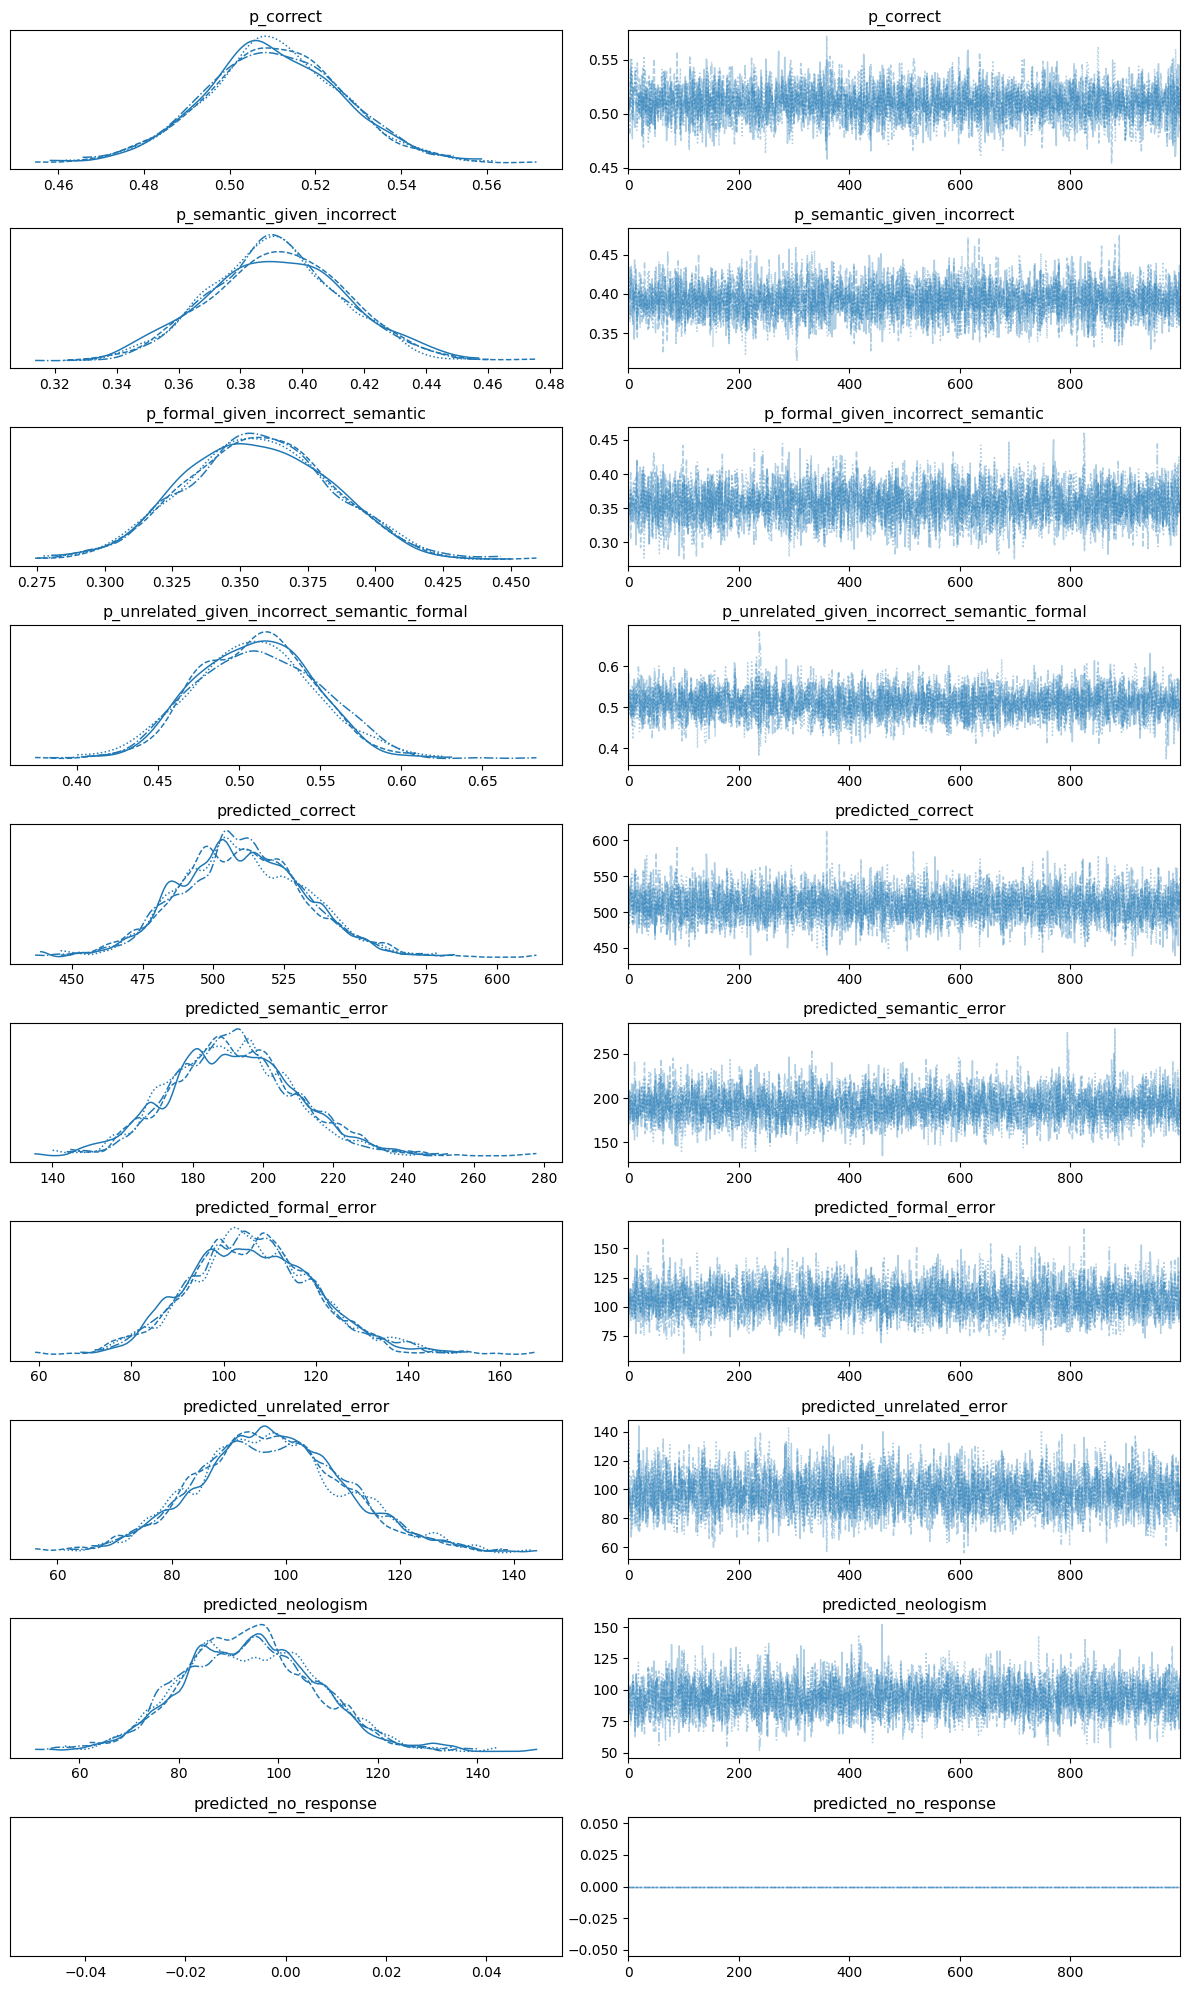

In [63]:
axarr = az.plot_trace(fit)
plt.tight_layout()